In [16]:
import base64
import torch
import cv2
import numpy as np
import supervision as sv
from segment_anything.bbox_prompt_mask_generator import SamBBoxMaskGenerator
from segment_anything import sam_model_registry

IS_COLAB = False

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

Helper function that loads an image before adding it to the widget

In [18]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [19]:
IMAGE_PATH = "../segment_anything/12ESFRTPLT01EXCERPT1_Equi-cog_15.png"

In [20]:
widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [21]:
widget.bboxes

[{'x': 98, 'y': 28, 'width': 84, 'height': 74, 'label': ''}]

In [25]:
# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 26, 'y': 106, 'width': 50, 'height': 93, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
boxes = torch.tensor([[
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
]])

In [26]:
sam = sam_model_registry['vit_b'](checkpoint='../ckpts/instseg_bb.pt', num_classes=5, image_size=224)
mask_generator = SamBBoxMaskGenerator(sam)

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb, boxes)

## Visualization

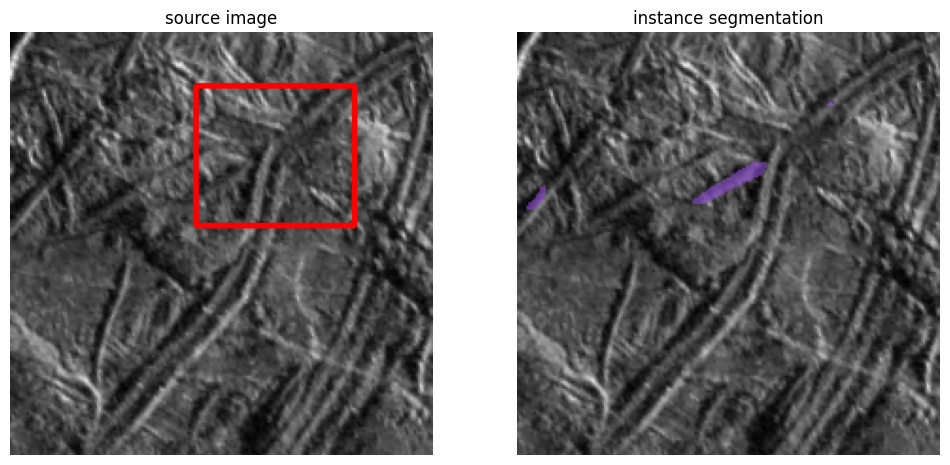

In [28]:
instances = (sam_result['segmentation'][:, 1:].sum(axis=1) > 0)
box_annotator = sv.BoundingBoxAnnotator(color=sv.Color.RED)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

instance_detections = sv.Detections(xyxy=boxes.numpy(), mask=instances, class_id=np.zeros(len(boxes)))
annotated_image_semantic = mask_annotator.annotate(scene=image_rgb.copy(), detections=instance_detections)
inp = box_annotator.annotate(scene=image_rgb.copy(), detections=instance_detections)

sv.plot_images_grid(
    images=[inp, annotated_image_semantic],
    grid_size=(1, 2),
    titles=['source image', 'instance segmentation'],
)